In [1]:
import pandas as pd
import seaborn as sns

sns.set_theme()

In [2]:
df = pd.read_csv("Result_4.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676494 entries, 0 to 676493
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   product_id  676494 non-null  int64  
 1   count       676494 non-null  int64  
 2   price       676494 non-null  float64
 3   total       676494 non-null  float64
 4   date        676494 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 25.8+ MB


In [8]:
df["date"] = pd.to_datetime(df['date'])
df['product_id'].mode()

selected_product = df[df['product_id'] == 30991620]
selected_product = selected_product.groupby(pd.Grouper(freq='YE', key='date')).sum().reset_index()
selected_product.date.min()


Timestamp('2018-12-31 00:00:00')

<Axes: xlabel='date', ylabel='count'>

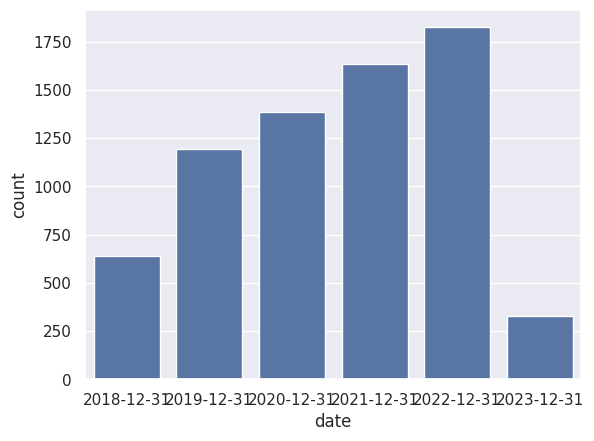

In [9]:

_ = selected_product.copy()
_['Month'] = (selected_product['date'] - pd.to_datetime('2018-03-31')).apply(lambda x: x.days / 30)


sns.barplot(data=selected_product, x='date', y='count')